# Conda GreenSurge faugeree

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import ocsmesh
import pyproj
import xarray as xr
from bluemath_tk.topo_bathy.mesh_utils import (
    adcirc2netcdf,
    buffer_aera,
    clip_bathymetry,
    define_mesh_target_size,
    detect_circumcenter_too_close,
    mask_points_outside_polygon,
    plot_bathymetry,
    plot_bathymetry_interp,
    plot_boundaries,
    plot_mesh_edge,
    plot_mesh_vals,
    read_adcirc_grd,
)
from bluemath_tk.topo_bathy.OCSMod import EuclideanMesh2D
from pyproj import CRS
from pyproj.enums import TransformDirection
from shapely.geometry import MultiPolygon, Point, Polygon
from shapely.ops import transform

## General parameters

### Names and paths

In [2]:
figsize = (7, 7)

In [3]:
bathymetry_tif_raw_path = "/home/grupos/geocean/faugeree/BlueMath/methods/hybrid_downscaling/additive/GreenSurge/inputs/Tonga_inv_V2.tif"

initial_raster_paths = [bathymetry_tif_raw_path]
output_bathy_clip_tif_path = "/home/grupos/geocean/faugeree/BlueMath/methods/hybrid_downscaling/additive/GreenSurge/outputs/NOAA_10m_6634_LMSL_clip.tif"

site = "Tonga"

### GreenSurge parameters

In [4]:
wind_speed = 40
direction_step = 15
simulation_duration_hours = 12
simulation_time_step_hours = 1/4
forcing_time_step = simulation_time_step_hours

reference_date = [2022, 1, 1, 0, 0, 0]
reference_date_dt = datetime(*reference_date)

Eddy = 10
Chezy = 70

In [5]:
# Forcing Setup
forcing_cell_size = 16 * 1000
Wind_effect_max_depth = -150

Mean_Sea_Level = 0


In [6]:
point = Point(-175.18531, -21.20102)

coords = [
    [-175.4842625874, -20.6200013383],
    [-174.7444556220, -20.6187918446],
    [-174.7446572043, -21.6460551405],
    [-175.4845145652, -21.6468110740],
    [-175.4842625874, -20.6200013383],
]

## Raster

In [7]:
lon_center = np.mean(np.array(coords)[-1, 0])
lat_center = np.mean(np.array(coords)[-1, 1])

proj_str = (
    f"+proj=aeqd +lat_0={lat_center} +lon_0={lon_center} +units=m +datum=WGS84 +no_defs"
)
project = pyproj.Transformer.from_crs("EPSG:4326", proj_str, always_xy=True).transform

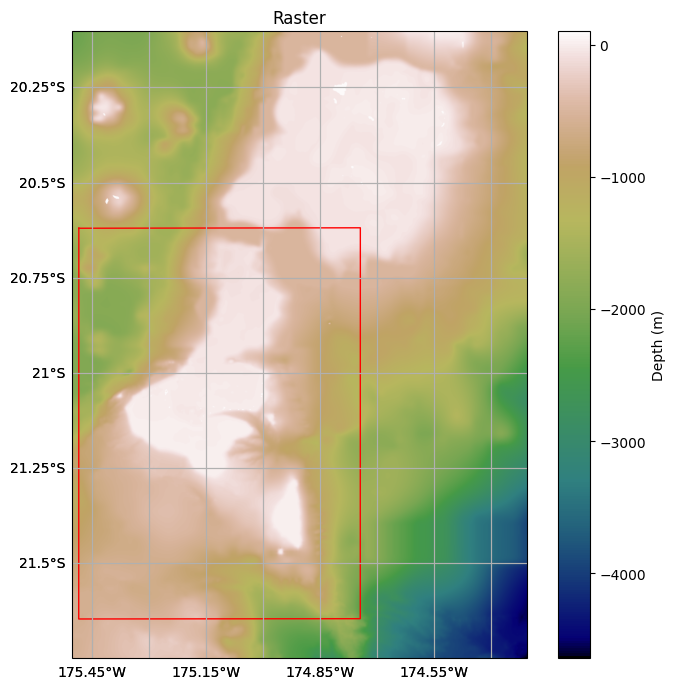

In [8]:
domain_crs = CRS.from_user_input("epsg:4326")
domain_polygon = Polygon(coords)


fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=figsize)
plot_bathymetry(initial_raster_paths, domain_polygon, ax)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.tight_layout()
plt.show()

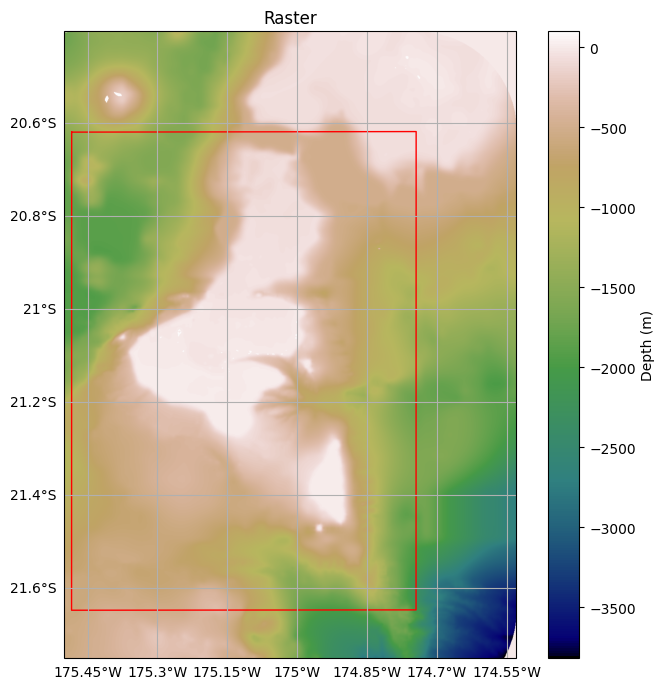

In [9]:
raster_resolution = clip_bathymetry(
    input_raster_paths=initial_raster_paths,
    output_path=output_bathy_clip_tif_path,
    domain=domain_polygon,
    margin=1,
)
clipped_raster_paths = [output_bathy_clip_tif_path]

x_center, y_center = project(lon_center, lat_center)
x_center_raster_resolution, y_center_raster_resolution = project(
    lon_center + raster_resolution / np.sqrt(2),
    lat_center + raster_resolution / np.sqrt(2),
)
raster_resolution_meters = np.mean(
    [
        abs(x_center - x_center_raster_resolution),
        abs(y_center - y_center_raster_resolution),
    ]
)

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=figsize)
plot_bathymetry(clipped_raster_paths, domain_polygon, ax)
plt.tight_layout()
plt.show()

## Computacional Grid

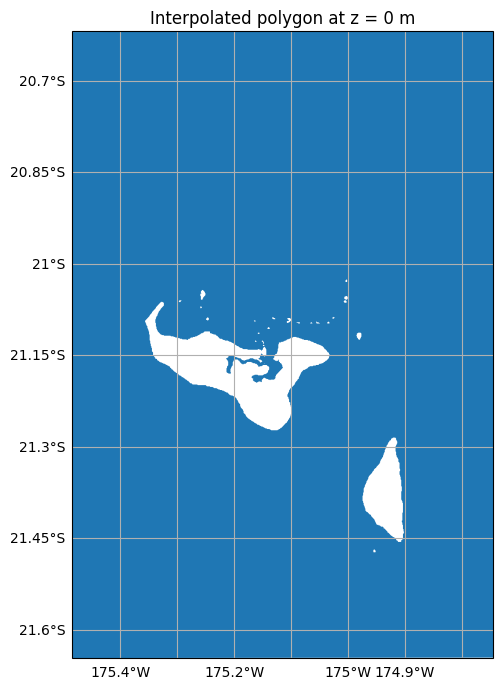

In [10]:
rasters = [ocsmesh.Raster(path) for path in clipped_raster_paths]
coastal_area = ocsmesh.Geom(rasters, zmax=Mean_Sea_Level).get_multipolygon()
intersected = coastal_area.intersection(domain_polygon)
if isinstance(intersected, MultiPolygon):
    intersected_area = max(intersected.geoms, key=lambda p: p.area)
else:
    intersected_area = intersected

gdf = gpd.GeoSeries([intersected_area], crs="EPSG:4326")
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=figsize)
minx, miny, maxx, maxy = gdf.total_bounds
gdf.plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_title(f"Interpolated polygon at z = {Mean_Sea_Level} m")
ax.set_extent([minx, maxx, miny, maxy], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.tight_layout()
plt.show()

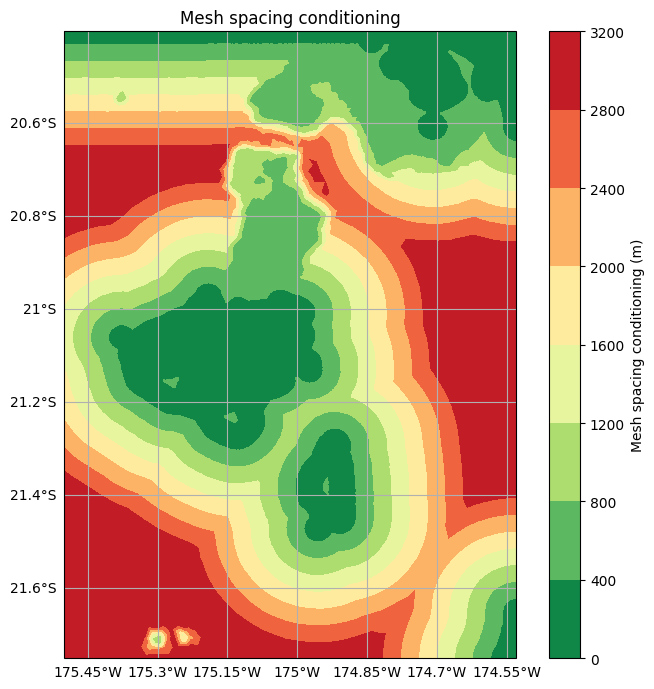

In [11]:
geometry = ocsmesh.Geom(
    [],
    base_shape=intersected_area,
    base_shape_crs=domain_crs,
)
domain_multipolygon = geometry.get_multipolygon()

# Define depth zones with mesh size and transition rate per range
# Format: (lower_bound, upper_bound): {'value': mesh_size, 'rate': expansion_rate}
expention_rate = 0.001
depth_ranges = {
    (-200_000, -250): {"value": 3000, "rate": expention_rate},  # Very deep ocean
    (-250, -100): {"value": 1000, "rate": expention_rate},  # Continental slope
    (-100, -75): {"value": 800, "rate": expention_rate},  # Outer shelf
    (-75, -25): {"value": 500, "rate": expention_rate},  # Mid shelf
    (-25, 2.5): {"value": 100, "rate": expention_rate},  # Coastal zone
}

mesh_spacing = define_mesh_target_size(
    rasters, raster_resolution_meters, depth_ranges=depth_ranges, nprocs=16
)

mesh_spacing_field = mesh_spacing.msh_t()

CRS_OCS = mesh_spacing_field.crs
to_LL = pyproj.Transformer.from_crs(CRS_OCS, "EPSG:4326", always_xy=True).transform

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=figsize)
plot_mesh_vals(mesh_spacing_field, ax=ax, to_geo=to_LL, cmap="RdYlGn_r")
ax.set_title("Mesh spacing conditioning")
plt.tight_layout()

In [12]:
driver = ocsmesh.JigsawDriver(geom=geometry, hfun=mesh_spacing, initial_mesh=False)
mesh = driver.run(remesh_tiny_elements=True)
mesh.interpolate(rasters, method="linear")

In [13]:
copy_mesh = EuclideanMesh2D(mesh.msh_t)
data_mesh = copy_mesh.vert2
node_coords = np.array([item["coord"] for item in data_mesh])
elements = np.array(list(ocsmesh.utils.elements(mesh.msh_t).values()))

In [14]:
def to_geo(x, y):
    return to_LL(x, y, direction=TransformDirection.INVERSE)

#intersected_area_UTM = transform(to_geo, intersected_area)                              # clean island too
intersected_area_UTM = Polygon(transform(to_geo, intersected_area).exterior.coords)     # only clean boondary
intersected_area_UTM_extended = buffer_aera(intersected_area_UTM, 0.0001)

mask_generation_outside = mask_points_outside_polygon(
    elements, node_coords, intersected_area_UTM_extended
)
print(f"Number of elements outside the polygon: {mask_generation_outside.sum()}")

mask_circumcenter = detect_circumcenter_too_close(
    node_coords[:, 0], node_coords[:, 1], elements
)
print(f"Number of elements with circumcenter too close: {mask_circumcenter.sum()}")

complete_mask = mask_generation_outside | mask_circumcenter

Number of elements outside the polygon: 0
Number of elements with circumcenter too close: 8


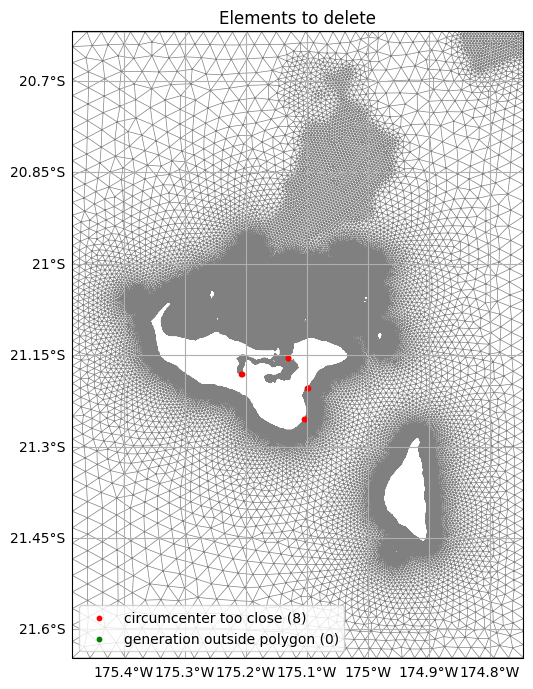

In [15]:
bad_elements_generation = np.mean(
    node_coords[elements[mask_generation_outside]], axis=1
)
bad_elements_circumcenter = np.mean(node_coords[elements[mask_circumcenter]], axis=1)

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=figsize)
plot_mesh_edge(copy_mesh.msh_t, to_geo=to_LL, ax=ax, color="gray", lw=0.5)


ax.scatter(
    *to_LL(
        bad_elements_circumcenter[:, 0].flatten(),
        bad_elements_circumcenter[:, 1].flatten(),
    ),
    color="red",
    s=10,
    label=f"circumcenter too close ({mask_circumcenter.sum()})",
)
ax.scatter(
    *to_LL(
        bad_elements_generation[:, 0].flatten(), bad_elements_generation[:, 1].flatten()
    ),
    color="green",
    s=10,
    label=f"generation outside polygon ({mask_generation_outside.sum()})",
)

ax.set_title("Elements to delete")
ax.legend()
plt.tight_layout()

In [16]:
cleaned_mesh = ocsmesh.utils.clip_elements_by_index(
    copy_mesh, tria=complete_mask, quad=None
)
ocsmesh.utils.finalize_mesh(cleaned_mesh)

No Land boundaries available. Error: 'geometry'


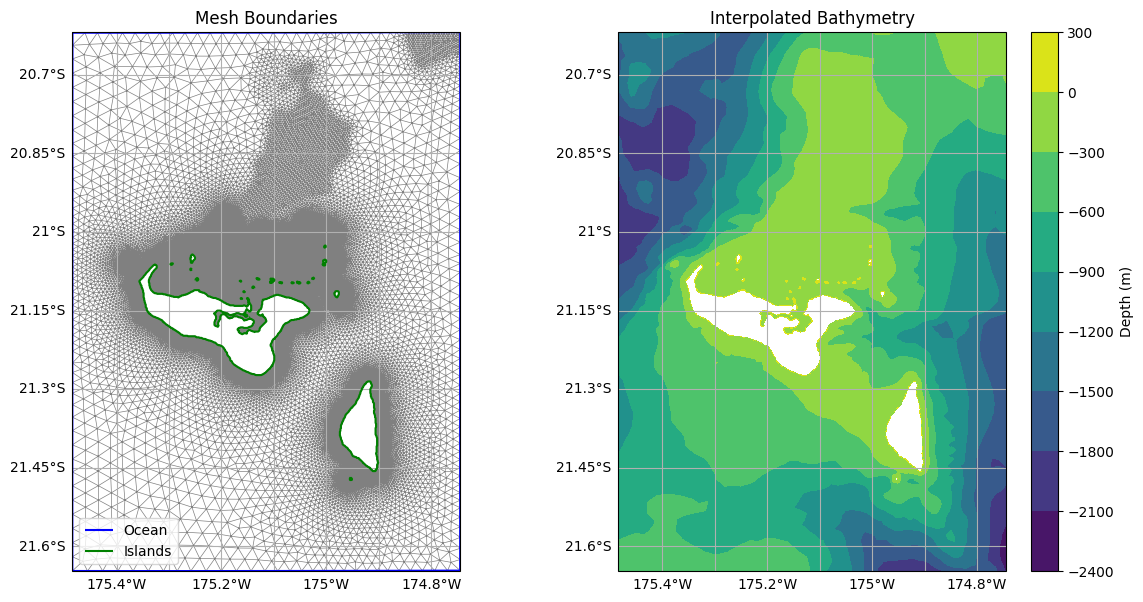

In [17]:
cleaned_mesh.interpolate(rasters, method="linear")
cleaned_mesh.boundaries.auto_generate(Mean_Sea_Level)

fig, (ax1, ax2) = plt.subplots(
    1,
    2,
    figsize=(figsize[0] * 2, figsize[1]),
    subplot_kw={"projection": ccrs.PlateCarree()},
)

plot_boundaries(cleaned_mesh, to_geo=to_LL, ax=ax1)
plot_bathymetry_interp(cleaned_mesh, to_LL, ax2)

In [18]:
path_grd_calc = f"/home/grupos/geocean/faugeree/BlueMath/methods/hybrid_downscaling/additive/GreenSurge/outputs/mesh_{site}_Calc_adcirc.grd"
cleaned_mesh.write(path_grd_calc, format="grd", overwrite=True)

In [19]:
netcdf_path = f"/home/grupos/geocean/faugeree/BlueMath/methods/hybrid_downscaling/additive/GreenSurge/templates/mesh_{site}_net.nc"
adcirc2netcdf(path_grd_calc, netcdf_path)

## Forcing Grid

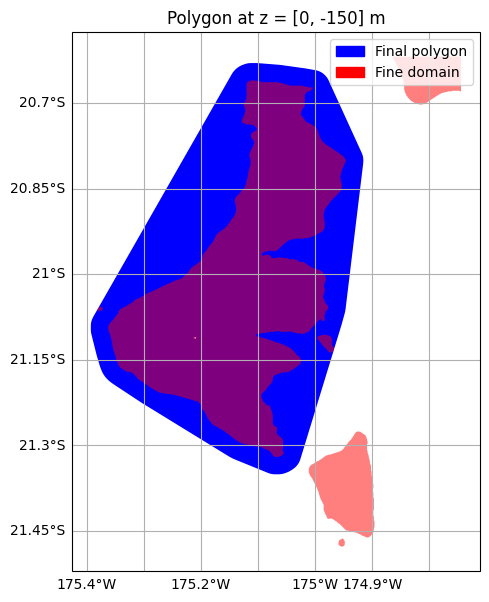

In [20]:
coarse_domain_clipped = (
    ocsmesh.Geom(rasters, zmax=Mean_Sea_Level)
    .get_multipolygon()
    .intersection(domain_polygon)
)
fine_domain_clipped = (
    ocsmesh.Geom(rasters, zmin=Wind_effect_max_depth)
    .get_multipolygon()
    .intersection(domain_polygon)
)

for polygon in fine_domain_clipped.geoms:
    if polygon.contains(point):
        selected_polygon = polygon
        break

envelope = selected_polygon.convex_hull
coarse_minus_envelope = coarse_domain_clipped.difference(envelope)
refined_shape = coarse_domain_clipped.difference(coarse_minus_envelope)

if isinstance(refined_shape, MultiPolygon):
    largest_polygon = max(refined_shape.geoms, key=lambda p: p.area)
else:
    largest_polygon = refined_shape

cleaned_polygon = Polygon(largest_polygon.exterior)
outer_buffered = buffer_aera(cleaned_polygon, 0.3)
inner_buffered = buffer_aera(selected_polygon, -2)

final_polygon = outer_buffered.difference(inner_buffered)

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=figsize)
gpd.GeoSeries(final_polygon).plot(ax=ax, color="blue")
gpd.GeoSeries(fine_domain_clipped).plot(ax=ax, color="red", alpha=0.5)

final_polygon_patch = mpatches.Patch(color="blue", label="Final polygon")
fine_domain_patch = mpatches.Patch(color="red", label="Fine domain")
ax.legend(handles=[final_polygon_patch, fine_domain_patch], loc="best")
ax.set_title(f"Polygon at z = [{Mean_Sea_Level}, {Wind_effect_max_depth}] m")
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

Text(0.5, 1.0, 'GreenSurge final forcing grid')

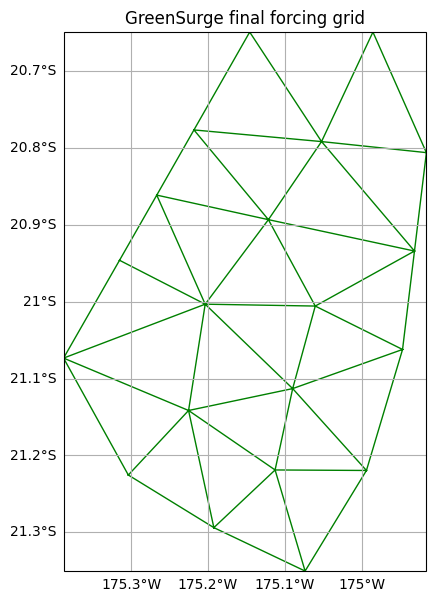

In [21]:
geom_forz = ocsmesh.Geom(
    [],
    base_shape=final_polygon,
    base_shape_crs=domain_crs,
)
domain_poly = geom_forz.get_multipolygon()

depth_ranges_forcing = {
    (-200_000, -250): {"value": forcing_cell_size, "rate": None},
}

hfun_forz = define_mesh_target_size(
    rasters, raster_resolution_meters, depth_ranges=depth_ranges_forcing
)

driver_forz = ocsmesh.JigsawDriver(
    geom=geom_forz,
    hfun=hfun_forz,
    initial_mesh=False,
)
mesh_forz = driver_forz.run()

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=figsize)
plot_mesh_edge(mesh_forz.msh_t, to_geo=to_LL, ax=ax, color="green", lw=1)
ax.set_title("GreenSurge final forcing grid")

In [22]:
path_grd_forz = f"/home/grupos/geocean/faugeree/BlueMath/methods/hybrid_downscaling/additive/GreenSurge/outputs/mesh_{site}_Viento_adcirc.grd"
mesh_forz.write(path_grd_forz, format="grd", overwrite=True)

## GreenSurge Setup Summary

In [23]:
Nodes_calc, Elmts_calc, lines_calc = read_adcirc_grd(path_grd_calc)
Nodes_forz, Elmts_forz, lines_forz = read_adcirc_grd(path_grd_forz)

### Presentacion malla

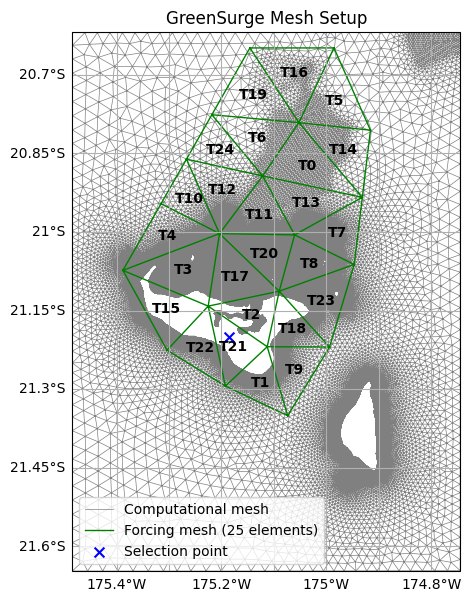

In [24]:
num_elements = len(Elmts_forz)

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=figsize)

ax.triplot(
    Nodes_calc[:, 1],
    Nodes_calc[:, 2],
    Elmts_calc[:, 2:5],
    color="grey",
    linestyle="-",
    marker="",
    linewidth=1 / 2,
    label="Computational mesh",
)
ax.triplot(
    Nodes_forz[:, 1],
    Nodes_forz[:, 2],
    Elmts_forz[:, 2:5],
    color="green",
    linestyle="-",
    marker="",
    linewidth=1,
    label=f"Forcing mesh ({num_elements} elements)",
)
ax.scatter(
    point.coords[0][0],
    point.coords[0][1],
    marker="x",
    color="blue",
    s=50,
    label="Selection point",
)

for t in range(num_elements):
    node0, node1, node2 = Elmts_forz[t, 2:5]
    x = (
        Nodes_forz[int(node0), 1]
        + Nodes_forz[int(node1), 1]
        + Nodes_forz[int(node2), 1]
    ) / 3
    y = (
        Nodes_forz[int(node0), 2]
        + Nodes_forz[int(node1), 2]
        + Nodes_forz[int(node2), 2]
    ) / 3
    plt.text(x, y, f"T{t}", fontsize=10, ha="center", va="center", fontweight="bold")

bnd = [
    min(Nodes_calc[:, 1].min(), Nodes_forz[:, 1].min()),
    max(Nodes_calc[:, 1].max(), Nodes_forz[:, 1].max()),
    min(Nodes_calc[:, 2].min(), Nodes_forz[:, 2].min()),
    max(Nodes_calc[:, 2].max(), Nodes_forz[:, 2].max()),
]
ax.set_extent([*bnd], crs=ccrs.PlateCarree())
plt.legend()
ax.set_title("GreenSurge Mesh Setup")
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

### Build simulation_dataset

In [25]:
triangle_node_indices = np.arange(3)

num_directions = int(360 / direction_step)
wind_directions = np.arange(0, 360, direction_step)
wind_direction_indices = np.arange(0, num_directions)

element_forcing_indices = np.arange(0, num_elements)
element_computation_indices = np.arange(0, len(Elmts_calc[:, 1]))

node_forcing_indices = np.arange(0, len(Nodes_forz[:, 1]))

time_forcing_index = [0, forcing_time_step, forcing_time_step + 0.001, simulation_duration_hours - 1]

node_cumputation_index = np.arange(0, len(Nodes_calc[:, 1]))

reference_date_str = reference_date_dt.strftime("%Y-%m-%d %H:%M:%S")

In [26]:
simulation_dataset = xr.Dataset(
    coords=dict(
        wind_direction_index=("wind_direction_index", wind_direction_indices),
        time_forcing_index=("time_forcing_index", time_forcing_index),
        node_computation_longitude=("node_cumputation_index", Nodes_calc[:, 1]),
        node_computation_latitude=("node_cumputation_index", Nodes_calc[:, 2]),
        triangle_nodes=("triangle_forcing_nodes", triangle_node_indices),
        node_forcing_index=("node_forcing_index", node_forcing_indices),
        element_forcing_index=("element_forcing_index", element_forcing_indices),
        node_cumputation_index=("node_cumputation_index", node_cumputation_index),
        element_computation_index=("element_computation_index", element_computation_indices),

    ),
    data_vars=dict(
        triangle_computation_connectivity=(("element_computation_index", "triangle_forcing_nodes"), Elmts_calc[:, 2:5].astype(int),
            {"description": "Indices of nodes forming each triangular element of the computational grid (counter-clockwise order)"}),

        node_forcing_longitude=("node_forcing_index", Nodes_forz[:, 1],
            {"units": "degrees_east", "description": "Longitude of each mesh node of the forcing grid"}),
        node_forcing_latitude=("node_forcing_index", Nodes_forz[:, 2],
            {"units": "degrees_north", "description": "Latitude of each mesh node of the forcing grid"}),
        triangle_forcing_connectivity=(("element_forcing_index", "triangle_forcing_nodes"), Elmts_forz[:, 2:5].astype(int),
            {"description": "Indices of nodes forming each triangular element of the forcing grid (counter-clockwise order)"}),

        wind_directions=("wind_direction_index", wind_directions,
            {"units": "degrees", "description": "Discretized wind directions (0 to 360°)"}),
        total_elements=((), num_elements,
            {"description": "Total number of triangular elements in the mesh"}),
        simulation_duration_hours=((), simulation_duration_hours,
            {"units": "hours", "description": "Total duration of the simulation"}),
        time_step_hours=((), simulation_time_step_hours,
            {"units": "hours", "description": "Time step used in the simulation"}),
        wind_speed=((), wind_speed,
            {"units": "m/s", "description": "Wind speed for each discretized direction"}),
        location_name=((), site,
            {"description": "Name of case study location"}),
        eddy_viscosity=((), Eddy,
            {"units": "m²/s", "description": "Eddy viscosity used in the simulation"}),
        chezy_coefficient=((), Chezy,
            {"description": "Chezy coefficient used for bottom friction"}),
        reference_date=((), reference_date_str,
            {"description": "Reference start date of the simulation"}),
        forcing_time_step=((), forcing_time_step,
            {"units": "hour", "description": "Time step used for applying external forcing data"}),
    )
)

simulation_dataset["time_forcing_index"].attrs = {
    "standard_name": "time",
    "long_name": f"Time - hours since {reference_date_str} +00:00",
    "time_origin": f"{reference_date_str}",
    "units": f"hours since {reference_date_str} +00:00",
    "calendar": "gregorian",
    "description": "Time definition for the forcing data",
}

simulation_dataset["node_computation_longitude"].attrs = {
    "description": "Longitude of each mesh node of the computational grid",
    "standard_name": "longitude",
    "long_name": "longitude",
    "units": "degrees_east"
}
simulation_dataset["node_computation_latitude"].attrs = {
    "description": "Latitude of each mesh node of the computational grid",
    "standard_name": "latitude",
    "long_name": "latitude",
    "units": "degrees_north"
}


simulation_dataset.attrs = {
    "title": "Hybrid Simulation Input Dataset",
    "description": "Structured dataset containing simulation parameters for hybrid modeling.",
    "created": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "institution": "GeoOcean",
    "model": "GreenSurge",
}

simulation_dataset.to_netcdf(
    f"/home/grupos/geocean/faugeree/BlueMath/methods/hybrid_downscaling/additive/GreenSurge/outputs/GreenSurge_{site}_info.nc",
    "w",
    "NETCDF3_CLASSIC",
    unlimited_dims="time",
)

In [27]:
simulation_dataset

<xarray.Dataset> Size: 7MB
Dimensions:                            (element_computation_index: 151076,
                                        triangle_forcing_nodes: 3,
                                        node_forcing_index: 20,
                                        element_forcing_index: 25,
                                        wind_direction_index: 24,
                                        time_forcing_index: 4,
                                        node_cumputation_index: 76754)
Coordinates:
  * wind_direction_index               (wind_direction_index) int64 192B 0 .....
  * time_forcing_index                 (time_forcing_index) float64 32B 0.0 ....
    node_computation_longitude         (node_cumputation_index) float64 614kB ...
    node_computation_latitude          (node_cumputation_index) float64 614kB ...
    triangle_nodes                     (triangle_forcing_nodes) int64 24B 0 1 2
  * node_forcing_index                 (node_forcing_index) int64 160B 0 ... 19
  * element_forcing_index              (element_forcing_index) int64 200B 0 ....
  * node_cumputation_index             (node_cumputation_index) int64 614kB 0...
  * element_computation_index          (element_computation_index) int64 1MB ...
Dimensions without coordinates: triangle_forcing_nodes
Data variables: (12/14)
    triangle_computation_connectivity  (element_computation_index, triangle_forcing_nodes) int64 4MB ...
    node_forcing_longitude             (node_forcing_index) float64 160B -175...
    node_forcing_latitude              (node_forcing_index) float64 160B -21....
    triangle_forcing_connectivity      (element_forcing_index, triangle_forcing_nodes) int64 600B ...
    wind_directions                    (wind_direction_index) int64 192B 0 .....
    total_elements                     int64 8B 25
    ...                                 ...
    wind_speed                         int64 8B 40
    location_name                      <U5 20B 'Tonga'
    eddy_viscosity                     int64 8B 10
    chezy_coefficient                  int64 8B 70
    reference_date                     <U19 76B '2022-01-01 00:00:00'
    forcing_time_step                  float64 8B 0.25
Attributes:
    title:        Hybrid Simulation Input Dataset
    description:  Structured dataset containing simulation parameters for hyb...
    created:      2025-05-31 15:29:42
    institution:  GeoOcean
    model:        GreenSurge